In [ ]:
import asyncio, signal, socket, select, threading, time, struct
from websockets import server, exceptions
import matplotlib.pyplot as plt
from IPython import display

HOST, PORT = '127.0.0.1', 8765

try:
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.connect(('8.8.8.8', 1)) # doesn't even have to be reachable
    HOST = sock.getsockname()[0]
    print(f'HOST IP: {HOST}')
except Exception as error: print(error)
finally: sock.close()

def lines(a): return a.split('\n')

In [ ]:
def unpack_uint64(buffer, ii, byteorder='little'): return _unpack(buffer, ii, 8, byteorder)
def unpack_uint32(buffer, ii, byteorder='little'): return _unpack(buffer, ii, 4, byteorder)
def unpack_uint16(buffer, ii, byteorder='little'): return _unpack(buffer, ii, 2, byteorder)

def _unpack(buffer, ii, nbytes, byteorder):
    value = 0
    if byteorder == 'big':
        for i in range(nbytes): value |= buffer[ii+i] << (nbytes-1-i)*8
    elif byteorder == 'little':
        for i in range(nbytes): value |= buffer[ii+i] << i*8
    else: 
        assert False, f'unsupported byteorder: {byteorder}'
        
    return value

In [ ]:
class SampleWSServer:

    adc_to_voltage = 3.3 / 4095
    sample_size = 4 + 2 # bytes
    plot_refresh_time = 3 # sec
    
    def __init__(self):
        self.doexit = False
        self.last_plt_time = 0
        self.msg_recv_count = 0
        self.times, self.times_b = [], []
        self.voltage, self.voltage_b = [], []
        self.freq, self.prev_freq = 98.0, 98.0
        self.winsz = 0.25 # seconds
        self.runfut = None
        
        self.udphandler = threading.Thread(target=self.udp_handler)
        self.udphandler.start()
        
        signal.signal(signal.SIGINT, self.sighandler)
        signal.signal(signal.SIGTERM, self.sighandler)

    def sighandler(self, *args):
        self.doexit = True

    async def shutdown(self, interval=1):
        while not self.doexit: 
            await asyncio.sleep(interval)

        self.udphandler.join() # Blocks
        self.fut.set_result(None) # Mark future as done with None result        
    
    async def echo(self, websocket):
        try:
            async for message in websocket:
                await websocket.send(message)
                print(message)
        except exceptions.ConnectionClosed as exc:
            print(exc)
    
    async def send_freq(self, websocket):
        try: 
            await websocket.send(str(self.freq))
            self.prev_freq = self.freq
            
        except exceptions.ConnectionClosed as exc: 
            print(exc)

    def udp_handler(self):
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        sock.bind(("127.0.0.1", 5050))
        sock.settimeout(1.5)
        
        while not self.doexit:
            if not select.select([sock], [], [], 1.5)[0]: continue
            data, addr = sock.recvfrom(128) # buffer size is 128 bytes
            fdata, wdata = data.decode("utf-8").split(":")
            self.freq, self.winsz = float(fdata), float(wdata)
    
    async def wss_handler(self, websocket):
        try:
            async for msg in websocket:
                self.msg_recv_count += 1
                self.update_sample_data(msg)
                if self.freq != self.prev_freq: await self.send_freq(websocket)
                if time.time() - self.last_plt_time > self.plot_refresh_time:
                    self.display_graph()

        except exceptions.ConnectionClosed as exc:
            # Cycle the server, mark future as done with None result
            self.fut.set_result(None) 
            print(exc)        
    
    def update_sample_data(self, data): #{
        for i in range(0, len(data), self.sample_size):
            smpkt = data[i:i+self.sample_size]
            self.times.append(unpack_uint32(smpkt, ii=0) * 1e-6)
            self.voltage.append(unpack_uint16(smpkt, ii=4) * self.adc_to_voltage)

        if self.times[-1] - self.times[0] >= self.winsz:
            self.times_b, self.voltage_b = self.times, self.voltage
            self.times, self.voltage = [], []        
    #}
    
    def display_graph(self):
        display.clear_output(wait=True)        
        fig, ax = plt.subplots(figsize=(10, 3), constrained_layout=True)
        title = f'Msg count: {self.msg_recv_count}, Winsz: {self.winsz:.04f}, Freq: {self.freq:.02f}'
        ax.set(title=title, xlabel='time (s)', ylabel='V(t) (V)')
        ax.plot(self.times_b, self.voltage_b); ax.grid()
        self.last_plt_time = time.time()
        plt.show()
    
    async def run(self):
        while not self.doexit: 
            async with server.serve(self.wss_handler, host=HOST, port=PORT):
                print(f'Serving at: ws://{HOST}:{PORT}')
                loop = asyncio.get_running_loop()
                self.fut = loop.create_future()
                loop.create_task(self.shutdown())
                await self.fut # run forever or until SIGNAL

wsserver = SampleWSServer()
await wsserver.run()

In [ ]:
from struct import pack

ESP_UDP_IP = "192.168.0.14"
ESP_UDP_PORT = 4645

udpSocket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

freq, emid, fcnt = 98.0, 0, 55
for _ in range(100):
    buffer = pack("<dII", freq, emid, fcnt)
    udpSocket.sendto(buffer, (ESP_UDP_IP, ESP_UDP_PORT))
    time.sleep(2)

    freq *= 1.5
    fcnt += 1

In [ ]:
# UdpFreqMsg(764.5, 1, 3)
freq, emid, fcnt = 764.5, 1, 3
buffer = struct.pack("<dII", freq, emid, fcnt)
[int(bt) for bt in buffer]

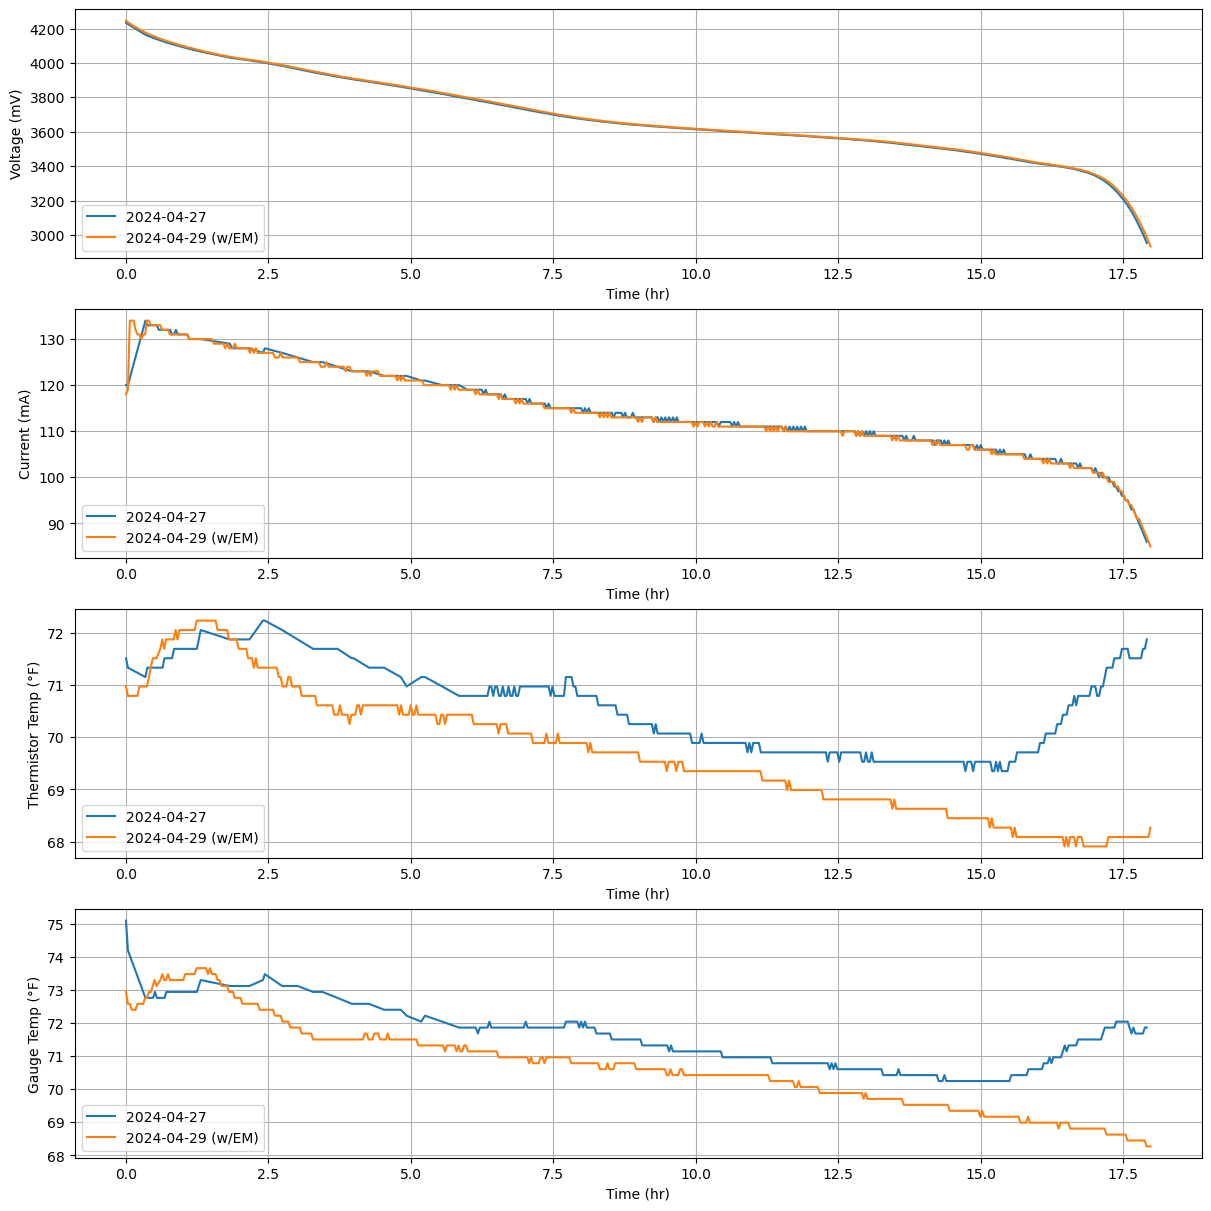

In [34]:
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import localtime, strftime
from datetime import datetime

def graphparse(fname, field, ffcn=None):
    x, y = [], []
    with open(f'lipotests/{fname}') as lfile:
        for ln in lfile:
            pattern = f'(\d{{4}}-\d{{2}}-\d{{2}}T\d{{2}}:\d{{2}}:\d{{2}}) {field} (\d+)'
            matchobj = re.match(pattern, ln)
            if matchobj:
                dt = datetime.strptime(matchobj.group(1), '%Y-%m-%dT%H:%M:%S')
                x.append(dt.timestamp() / 3600)

                value = int(matchobj.group(2))
                if ffcn: value = ffcn(value)
                y.append(value)

    for i in range(len(x)-1, -1, -1): x[i] -= x[0]
    return x, y
#}

def to_abs_signed16(value):
    return abs(value if value < (2**16 / 2) else value - (2**16 + 1))

def to_fahrenheit(value):
    return ((value/10) - 273.15) * (9/5) + 32 # from 0.1 Kelvin


x1, y1 = graphparse('LipoTest_2024-04-27_1.log', 'Voltage')
x2, y2 = graphparse('LipoEMTest_2024-04-29_1.log', 'Voltage')

x3, y3 = graphparse('LipoTest_2024-04-27_1.log', 'Current', ffcn=to_abs_signed16)
x4, y4 = graphparse('LipoEMTest_2024-04-29_1.log', 'Current', ffcn=to_abs_signed16)

x5, y5 = graphparse('LipoTest_2024-04-27_1.log', 'Temperature', ffcn=to_fahrenheit)
x6, y6 = graphparse('LipoEMTest_2024-04-29_1.log', 'Temperature', ffcn=to_fahrenheit)

x7, y7 = graphparse('LipoTest_2024-04-27_1.log', 'InternalTemperature', ffcn=to_fahrenheit)
x8, y8 = graphparse('LipoEMTest_2024-04-29_1.log', 'InternalTemperature', ffcn=to_fahrenheit)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
ax[0].set_xlabel('Time (hr)')
ax[0].set_ylabel('Voltage (mV)')
ax[0].plot(x1, y1, label='2024-04-27')
ax[0].plot(x2, y2, label='2024-04-29 (w/EM)')
ax[0].legend(loc='lower left')
ax[0].grid(True)

ax[1].set_xlabel('Time (hr)')
ax[1].set_ylabel('Current (mA)')
ax[1].plot(x3, y3, label='2024-04-27')
ax[1].plot(x4, y4, label='2024-04-29 (w/EM)')
ax[1].legend(loc='lower left')
ax[1].grid(True)

ax[2].set_xlabel('Time (hr)')
ax[2].set_ylabel('Thermistor Temp (°F)')
ax[2].plot(x5, y5, label='2024-04-27')
ax[2].plot(x6, y6, label='2024-04-29 (w/EM)')
ax[2].legend(loc='lower left')
ax[2].grid(True)

ax[3].set_xlabel('Time (hr)')
ax[3].set_ylabel('Gauge Temp (°F)')
ax[3].plot(x7, y7, label='2024-04-27')
ax[3].plot(x8, y8, label='2024-04-29 (w/EM)')
ax[3].legend(loc='lower left')
ax[3].grid(True)

plt.show()

In [ ]:
def to_sec(dtstring):
    return int(datetime.strptime(dtstring, '%Y-%m-%dT%H:%M:%S').timestamp())

v36 = to_durstr(to_sec("2024-04-28T01:07:00") - to_sec("2024-04-27T16:48:00"))
v35 = to_durstr(to_sec("2024-04-28T05:26:40") - to_sec("2024-04-27T16:48:00"))
rc0 = to_durstr(to_sec("2024-04-28T02:43:37") - to_sec("2024-04-27T16:48:00"))

v36, v35, rc0

In [31]:
from datetime import datetime

def to_durstr(elapsed_s):
    h, elapsed_s = divmod(elapsed_s, 3600)
    m, elapsed_s = divmod(elapsed_s, 60)
    h, m, s = int(h), int(m), int(elapsed_s)
    if (h,m,s) == (0,0,0): return '0s'

    return ''.join([
        f'{h}h' if h > 0 else '',
        f'{m}m' if m > 0 else '',
        f'{s}s' if s > 0 else ''])

def printcmd(cmd, value):
    maxint16 = (2**16 / 2)
    if cmd == 'Temperature': print(f'Temperature: {((value/10) - 273.15) * (9/5) + 32:.2f} °F')
    elif cmd == 'InternalTemperature': print(f'InternalTemperature: {((value/10) - 273.15) * (9/5) + 32:.2f} °F')
    elif cmd == 'Voltage': print(f'Voltage: {value * 1e-3:.2f} V')
    elif cmd == 'BatteryStatus': print(f'BatteryStatus: {value}')
    elif cmd == 'Current': print(f'Current: {value if value < maxint16 else value - (2**16 + 1)} mA')
    elif cmd == 'RemainingCapacity': print(f'RemainingCapacity: {value} mAh')
    elif cmd == 'FullChargeCapacity': print(f'FullChargeCapacity: {value} mAh')
    elif cmd == 'AverageCurrent': print(f'AverageCurrent: {value}')
    elif cmd == 'TimeToEmpty': print(f'TimeToEmpty: {value}')
    elif cmd == 'TimeToFull': print(f'TimeToFull: {value}')
    elif cmd == 'StandbyCurrent': print(f'StandbyCurrent: {value}')
    elif cmd == 'StandbyTimeToEmpty': print(f'StandbyTimeToEmpty: {value}')
    elif cmd == 'MaxLoadCurrent': print(f'MaxLoadCurrent: {value}')
    elif cmd == 'MaxLoadTimeToEmpty': print(f'MaxLoadTimeToEmpty: {value}')
    elif cmd == 'RawCoulombCount': print(f'RawCoulombCount: {value}')
    elif cmd == 'AveragePower': print(f'AveragePower: {value}')
    elif cmd == 'CycleCount': print(f'CycleCount: {value}')
    elif cmd == 'RelativeStateOfCharge': print(f'RelativeStateOfCharge: {value}')
    elif cmd == 'StateOfHealth': print(f'StateOfHealth: {value}')
    elif cmd == 'ChargeVoltage': print(f'ChargeVoltage: {value}')
    elif cmd == 'ChargeCurrent': print(f'ChargeCurrent: {value}')
    elif cmd == 'DesignCapacity': print(f'DesignCapacity: {value} mAh')
    elif cmd == 'OperationStatus':
        bitmap = f'{value:016b}'
        print(f'OperationStatus: ({bitmap[:8]} {bitmap[8:]})')
        print(f'  CFGUPDATE mode: {bitmap[5] == "1"}')
        print(f'  BTP threshold crossed: {bitmap[8] == "1"}')
        print(f'  Smoothing on RemainingCapacity(): {bitmap[9] == "1"}')
        print(f'  Gauge init complete: {bitmap[10] == "1"}')
        print(f'  FCC discharge cycle valid: {bitmap[11] == "1"}')
        print(f'  Voltage below EDV2: {bitmap[12] == "1"}')    
        if bitmap[13:15] == "11": print(f'  Security mode: SEALED')
        elif bitmap[13:15] == "10": print(f'  Security mode: UNSEALED')
        elif bitmap[13:15] == "01": print(f'  Security mode: FULL ACCESS')
        else: print(f'  Security mode: Invalid')
        print(f'  CALIBRATION mode: {"Enabled" if bitmap[15] == "1" else "Disabled"}')
    elif cmd == 'CFGUPDATETest': print(f'CFGUPDATETest: {value:016b}')
    elif cmd == 'WriteRAMDesignCapacity': print(f'WriteRAMDesignCapacity: {value:016b}')
    elif cmd == 'Special': print(f'Special: {value:016b}')
    elif cmd == 'Control': print(f'Control: {value:016b}')
    elif cmd == 'ManufacturerAccessControl':
        datablk = " ".join([f'{bval:02X}' for bval in value])
        print(f'ManufacturerAccessControl: {datablk}')

        ramaddr = (value[1] << 8) | value[0]
        dataval = (value[2] << 8) | value[3]
        if ramaddr in ramAddrMap:
            print(f'  RAM addr: 0x{ramaddr:04X} ({ramAddrMap[ramaddr]}), value: {dataval} (0x{dataval:04X})')
            if ramAddrMap[ramaddr] == "Registers : Operation Config A": printOpsConfigA(dataval)
        else: print(f'  Unrecognized RAM addr: 0x{ramaddr:04X}')
    elif cmd == 'Control/SubControl':
        datablk = " ".join([f'{bval:02X}' for bval in value])
        print(f'Control/SubControl: {datablk}')

        ctrlcmd = (value[1] << 8) | value[0]
        if ctrlcmd in ctrlSubCmdMap:
            if ctrlSubCmdMap[ctrlcmd] in ["DEVICE_NUMBER", "HW_VERSION"]:
                dataval = (value[3] << 8) | value[2]
                print(f'  I2CCTRLCMD: 0x{ctrlcmd:04X} ({ctrlSubCmdMap[ctrlcmd]}), value: {dataval} (0x{dataval:04X})')
            elif ctrlSubCmdMap[ctrlcmd] == "FW_VERSION":
                DVBT = {2: 'Device Number', 4: 'Version', 6: 'Build number', 8: 'Firmware type'}
                print(f'  I2CCTRLCMD: 0x{ctrlcmd:04X} ({ctrlSubCmdMap[ctrlcmd]})')
                for jj in range(2, 9, 2):
                    dataval = (value[jj] << 8) | value[jj+1]
                    print(f'    {DVBT[jj]}: {dataval} (0x{dataval:04X})')

        else: print(f'  Unrecognized I2CCTRLCMD: 0x{ctrlcmd:04X}')
    else: print(f"Invalid cid: {cid} ({ii} : {tupdata})")
#}

def parse(fname):
    cmdmap, initial, final = {}, None, None
    with open(f'lipotests/{fname}') as lfile:
        for ln in lfile:
            ln = ln.split()
            cmdmap[ln[1]] = int(ln[2])
            if initial is None: initial = ln[0]
            else: final = ln[0]
    #}

    initial = datetime.strptime(initial, '%Y-%m-%dT%H:%M:%S')
    final = datetime.strptime(final, '%Y-%m-%dT%H:%M:%S')
    tm = to_durstr(int(final.timestamp() - initial.timestamp()))

    print(f"Test time: {tm}")
    for cmd in cmdmap: printcmd(cmd, cmdmap[cmd])
#}

parse('LipoEMTest_2024-04-29_1.log')

Test time: 17h58m33s
Temperature: 68.27 °F
InternalTemperature: 68.27 °F
Voltage: 2.93 V
Current: -85 mA
RemainingCapacity: 0 mAh
FullChargeCapacity: 1285 mAh
OperationStatus: (11111111 11111111)
  CFGUPDATE mode: True
  BTP threshold crossed: True
  Smoothing on RemainingCapacity(): True
  Gauge init complete: True
  FCC discharge cycle valid: True
  Voltage below EDV2: True
  Security mode: SEALED
  CALIBRATION mode: Enabled
DesignCapacity: 980 mAh


In [ ]:
hex(int(b'00000100', 2)), hex(int(b'10000100', 2))